Copyright (c) Meta Platforms, Inc. and affiliates. All rights reserved. This source code is licensed under the license found in the LICENSE file in the root directory of this source tree.

# Video Seal - Image inference

In [1]:
# run in the root of the repository
%load_ext autoreload
%autoreload 2
%cd ..

/private/home/pfz/09-videoseal/fbresearch


In [2]:
import os
import omegaconf
from tqdm import tqdm
import gc
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision

from videoseal.utils.display import save_img
from videoseal.utils import Timer
from videoseal.evals.full import setup_model_from_checkpoint
from videoseal.evals.metrics import bit_accuracy, psnr, ssim
from videoseal.augmentation import Identity, JPEG
from videoseal.modules.jnd import JND

to_tensor = torchvision.transforms.ToTensor()
to_pil = torchvision.transforms.ToPILImage()

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu" 

def plot_images(original, watermarked, diff):
    # plot original image, watermarked image, and difference
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(original.permute(1, 2, 0).cpu().numpy())
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(watermarked.permute(1, 2, 0).cpu().numpy())
    axes[1].set_title("Watermarked Image")
    axes[1].axis("off")

    axes[2].imshow(diff.permute(1, 2, 0).cpu().numpy())
    axes[2].set_title("Difference Image")
    axes[2].axis("off")

    plt.show()


/private/home/pfz/miniconda3/envs/img/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/private/home/pfz/09-videoseal/fbresearch/videoseal/models/baselines.py:336: SyntaxWarning: invalid escape sequence '\;'
  assert os.path.exists(os.path.join('ckpts', 'hidden_encoder_48b.pt')), """


File /private/home/pfz/09-videoseal/fbresearch/ckpts/y_256b_img.pth exists, skipping download
Model loaded successfully from /private/home/pfz/09-videoseal/fbresearch/ckpts/y_256b_img.pth with message: <All keys matched successfully>


Processing Images:   0%|          | 0/1 [00:00<?, ?it/s]

{'file': 'assets/imgs/1.jpg', 'bit_accuracy': 1.0, 'psnr': 48.16840744018555, 'ssim': 0.997394859790802, 'bit_accuracy_qf80': 1.0, 'bit_accuracy_qf40': 0.96875}


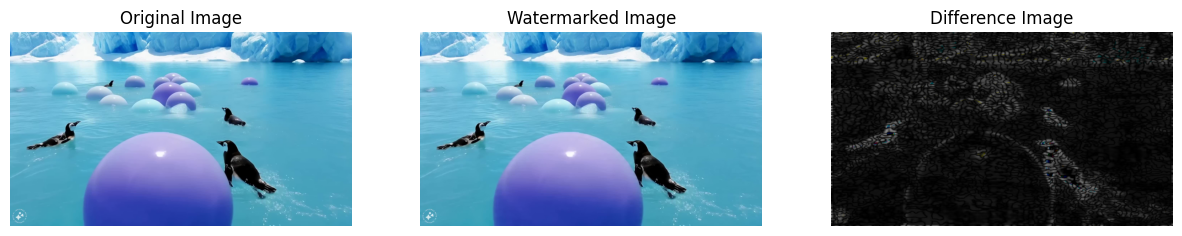

Processing Images: 100%|██████████| 1/1 [00:02<00:00,  2.89s/it]


In [3]:
# Directory containing images
num_imgs = 10
assets_dir = "assets/imgs"
base_output_dir = "outputs"
os.makedirs(base_output_dir, exist_ok=True)

# Checkpoint
ckpts = {
    # "trustmark": "baseline/trustmark",
    # "cin": "baseline/cin",
    # "mbrs": "baseline/mbrs",
    # "videoseal_0.0": 'videoseal_0.0',
    "videoseal": 'videoseal',
}

for ckpt_name, ckpt_path in ckpts.items():

    output_dir = os.path.join(base_output_dir, ckpt_name)
    os.makedirs(output_dir, exist_ok=True)

    # a timer to measure the time
    timer = Timer()

    # Iterate over all ckpts
    model = setup_model_from_checkpoint(ckpt_path)
    model.eval()
    model.compile()
    model.to(device)

    # control the watermark strength with this parameter. The higher the value, the more visible the watermark, but also the more robust it is to attacks.
    model.blender.scaling_w *= 1

    # Iterate over all video files in the directory
    files = [f for f in os.listdir(assets_dir) if f.endswith(".png") or f.endswith(".jpg")]
    files = [os.path.join(assets_dir, f) for f in files]
    files = files[:num_imgs]

    for file in tqdm(files, desc=f"Processing Images"):
        # load image
        imgs = Image.open(file, "r").convert("RGB")  # keep only rgb channels
        imgs = to_tensor(imgs).unsqueeze(0).float()

        # Watermark embedding
        timer.start()
        outputs = model.embed(imgs, is_video=False, lowres_attenuation=True)
        torch.cuda.synchronize()
        # print(f"embedding watermark  - took {timer.stop():.2f}s")

        # compute diff
        imgs_w = outputs["imgs_w"]  # b c h w
        msgs = outputs["msgs"]  # b k
        diff = imgs_w - imgs
        diff = 25 * diff.abs()

        # save
        timer.start()
        base_save_name = os.path.join(output_dir, os.path.basename(file).replace(".png", ""))
        save_img(imgs[0], f"{base_save_name}_ori.png")
        save_img(imgs_w[0], f"{base_save_name}_wm.png")
        save_img(diff[0], f"{base_save_name}_diff.png")

        # Metrics
        imgs_aug = imgs_w
        outputs = model.detect(imgs_aug, is_video=False)
        metrics = {
            "file": file,
            "bit_accuracy": bit_accuracy(
                outputs["preds"][:, 1:],
                msgs
            ).nanmean().item(),
            "psnr": psnr(imgs_w, imgs).item(),
            "ssim": ssim(imgs_w, imgs).item()
        }

        # Augment images
        for qf in [80, 40]:
            imgs_aug, _ = JPEG()(imgs_w, None,qf)

            # detect
            timer.start()
            outputs = model.detect(imgs_aug, is_video=True)
            preds = outputs["preds"]
            bit_preds = preds[:, 1:]  # b k ...
            bit_accuracy_ = bit_accuracy(
                bit_preds,
                msgs
            ).nanmean().item()
            
            metrics[f"bit_accuracy_qf{qf}"] = bit_accuracy_

        print(metrics)
        plot_images(imgs[0], imgs_w[0], diff[0])

        del outputs, imgs, imgs_w, diff

    # Free model from GPU
    del model
    torch.cuda.empty_cache()